## Import Libraries

In [94]:
# read hdf5 file and plot the data
import h5py
import numpy as np
import pandas as pd
import mne
import matplotlib.pyplot as plt
import plotly.express as px

## Load Data

In [95]:
# read the file
datafile_path = "../../data/"
# filename = datafile_path + "neck movement bottom left2024.03.01_10.53.24.hdf5"
filename = datafile_path + "neck movement bottom right2024.03.01_10.43.37.hdf5"
# data = None
with h5py.File(filename, "r") as f:
    # Print all root level object names (aka keys) 
    # these can be group or dataset names 
    print("Keys: %s" % f.keys())

    # List all the groups in the file
    print("\nGroups in the HDF5 file:")
    print(list(f.keys()))

    # Print all the groups and datasets
    print("\nGroups and datasets in the HDF5 file:")
    for key in f.keys():
        print(key, f[key])
    # Print al the datasets in the RawData group
    print("\nDatasets in the RawData group:")
    print(list(f['RawData'].keys()))

    # Access a specific group
    data_samples = f['RawData']['Samples'][:]
    f.close()

Keys: <KeysViewHDF5 ['AsynchronData', 'RawData', 'SavedFeatues', 'Version']>

Groups in the HDF5 file:
['AsynchronData', 'RawData', 'SavedFeatues', 'Version']

Groups and datasets in the HDF5 file:
AsynchronData <HDF5 group "/AsynchronData" (1 members)>
RawData <HDF5 group "/RawData" (6 members)>
SavedFeatues <HDF5 group "/SavedFeatues" (1 members)>
Version <HDF5 group "/Version" (1 members)>

Datasets in the RawData group:
['AcquisitionTaskDescription', 'DAQDeviceCapabilities', 'DAQDeviceDescription', 'Samples', 'SessionDescription', 'SubjectDescription']


In [96]:
# Set the data and time array
data_samples = data_samples[5120:]  # Remove the first 5120 data points (10 sec)
data_shape = data_samples.shape # (179218, 15)
sampling_rate = 512             # Hz
duration = data_shape[0] / 512  # seconds
channels = data_shape[1]        # 15 channels
num_points = data_shape[0]      # 179218
print(f"Data shape: {data_shape}, Sampling rate: {sampling_rate} Hz, Duration: {duration} seconds, Channels: {channels}")

# Generate time array
time = np.arange(0, duration, 1 / sampling_rate)

# Create a pandas DataFrame from the data
raw_data_df = pd.DataFrame(data_samples, columns=[f"Channel_{i+1}" for i in range(data_shape[1])])
raw_data_df['Time'] = time
raw_data_df.head()

Data shape: (39276, 8), Sampling rate: 512 Hz, Duration: 76.7109375 seconds, Channels: 8


,Channel_1,Channel_2,Channel_3,Channel_4,Channel_5,Channel_6,Channel_7,Channel_8,Time
0,-6879.553711,-4127.975586,900.232239,-4095.477783,3405.380127,-5412.820801,-7708.289551,1435.901245,0.000000
1,-6879.755859,-4127.335938,900.104736,-4094.882568,3405.459229,-5412.274414,-7708.387695,1436.750488,0.001953
2,-6880.062500,-4126.538574,900.071289,-4094.197998,3405.595703,-5411.648438,-7708.530273,1437.545654,0.003906
3,-6880.465820,-4125.637207,900.129456,-4093.455566,3405.780762,-5410.989258,-7708.701172,1438.223267,0.005859
4,-6880.949707,-4124.698242,900.267700,-4092.695801,3405.998535,-5410.353027,-7708.883789,1438.727783,0.007812


In [97]:
# Change the data units from microvolts to volts
# data_array = np.divide(data_samples.T,1e6)

# Pass the dataframes to MNE
info = mne.create_info(ch_names=[f"Channel_{i+1}" for i in range(data_shape[1])], sfreq=sampling_rate, ch_types='eeg')
raw_data = mne.io.RawArray(data_samples.T, info)


Creating RawArray with float64 data, n_channels=8, n_times=39276
    Range : 0 ... 39275 =      0.000 ...    76.709 secs
Ready.


## Plot Raw EEG Data

In [98]:
# Plot using plotly express
raw_data_df = raw_data_df[(raw_data_df['Time']>0) & (raw_data_df['Time']<120)]
fig = px.line(
    raw_data_df, 
    x='Time', 
    y=raw_data_df.columns, 
    title='Raw EEG Data from 15 Channels',
    labels={'Time': 'Time (seconds)', 'value': 'Microvolts [mV]'})
# fig.show()

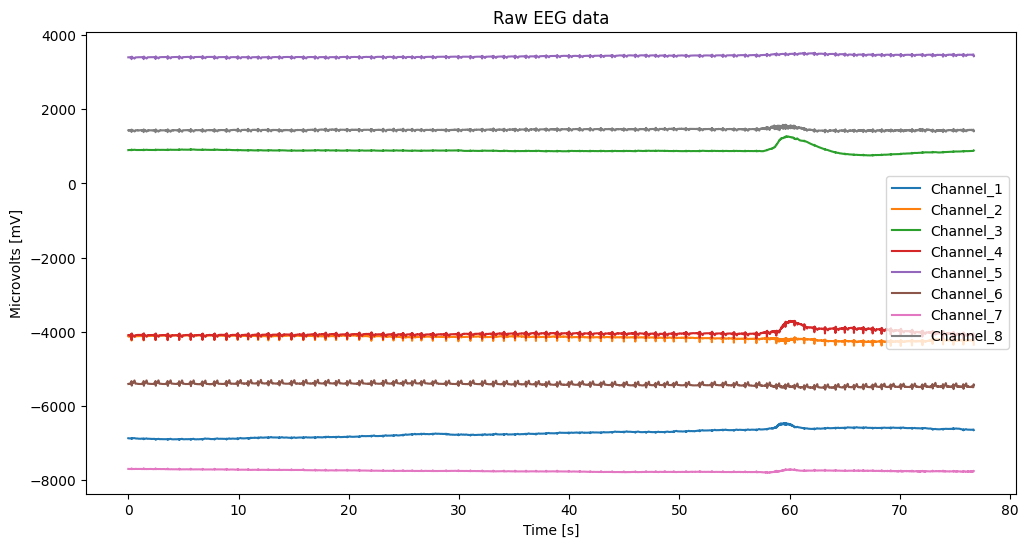

In [99]:
# Plot the raw EEG data using pyplot
# The data value on x-axis is recorded in 512 Hz, reformat the x-axis to seconds
x = np.arange(0, data_samples.shape[0], 1)
x = x / 512
# Plot the data
plt.figure(figsize=(12, 6))
plt.plot(x, data_samples)
plt.xlabel('Time [s]')
plt.ylabel('Microvolts [mV]')
plt.title('Raw EEG data')
# Add the channel names to the plot
plt.legend([f"Channel_{i+1}" for i in range(data_shape[1])])
plt.show()

## Apply Band-pass Filter

In [100]:
# Apply a bandpass filter to the data using MNE
band_filtered_eeg = raw_data.filter(l_freq=0.1, h_freq=30, fir_design="firwin2")
band_data = band_filtered_eeg.get_data()

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hamming window
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 33793 samples (66.002 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s finished


### Plot by Plotly Express

In [101]:
# Plot the filtered data using plotly express
band_data_df = pd.DataFrame(band_data.T, columns=[f"Channel_{i+1}" for i in range(band_data.shape[0])])
band_data_df['Time'] = band_filtered_eeg.times
band_data_df = band_data_df[(band_data_df['Time']>0) & (band_data_df['Time']<120)]
fig = px.line(
    band_data_df, 
    x='Time', 
    y=band_data_df.columns, 
    title='Filtered EEG Data from 15 Channels',
    labels={'Time': 'Time (seconds)', 'value': 'Microvolts [mV]'})
# fig.show()

### Plot by Pyplot

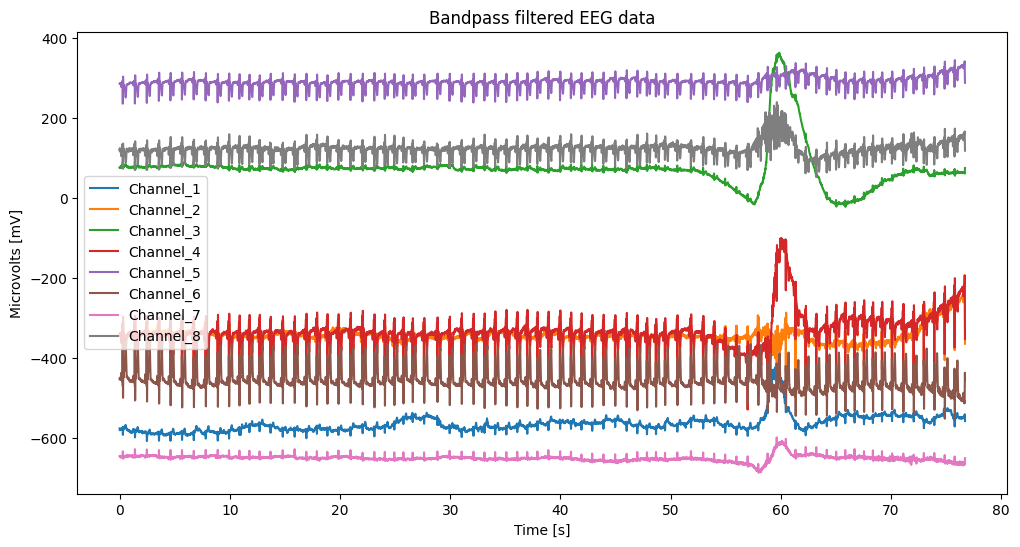

In [102]:
# Plot the bandpass filtered EEG data using pyplot
# The data value on x-axis is recorded in 512 Hz, reformat the x-axis to seconds
x = np.arange(0, data_samples.shape[0], 1)
x = x / 512
# Plot the data
plt.figure(figsize=(12, 6))
plt.plot(x, band_data.T)
plt.xlabel('Time [s]')
plt.ylabel('Microvolts [mV]')
plt.title('Bandpass filtered EEG data')
# Add the channel names to the plot
plt.legend([f"Channel_{i+1}" for i in range(data_shape[1])])
plt.show()

## Apply Notch Filter

In [103]:
# Apply notch filter to the data using MNE
notch_filtered_eeg = band_filtered_eeg.notch_filter(freqs=60)
notch_data = notch_filtered_eeg.get_data()

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.35
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 59.10 Hz)
- Upper passband edge: 60.65 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 60.90 Hz)
- Filter length: 3381 samples (6.604 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s finished


### Plot by Plotly Express

In [104]:
# Plot the notch filtered data using plotly express
notch_data_df = pd.DataFrame(notch_data.T, columns=[f"Channel_{i+1}" for i in range(notch_data.shape[0])])
notch_data_df['Time'] = notch_filtered_eeg.times
notch_data_df = notch_data_df[(notch_data_df['Time']>0) & (notch_data_df['Time']<120)]
fig = px.line(
    notch_data_df, 
    x='Time', 
    y=notch_data_df.columns, 
    title='Notch Filtered EEG Data from 15 Channels',
    labels={'Time': 'Time (seconds)', 'value': 'Microvolts [mV]'})
# fig.show()

### Plot by Pyplot

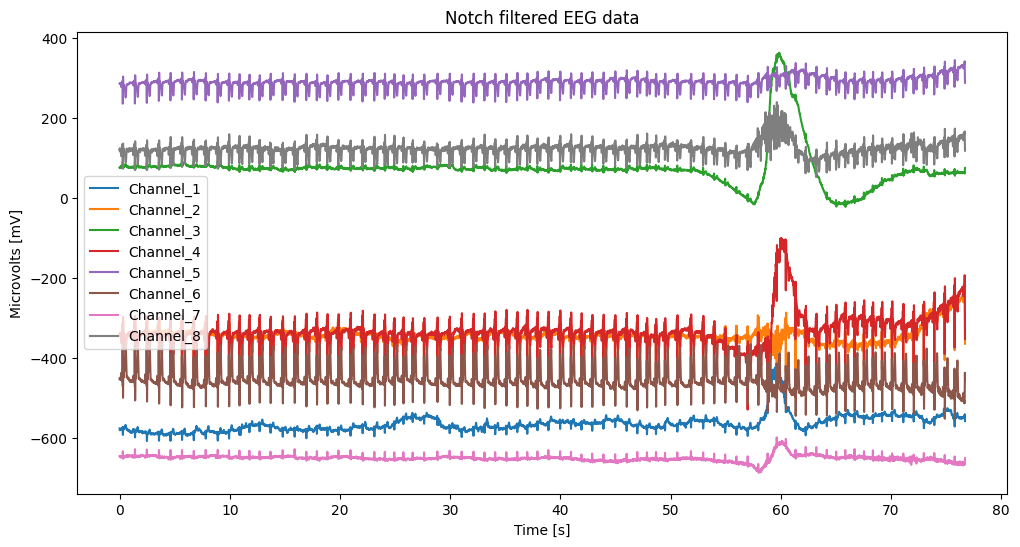

In [105]:
# Plot the notch filtered EEG data using pyplot
# The data value on x-axis is recorded in 512 Hz, reformat the x-axis to seconds
x = np.arange(0, data_samples.shape[0], 1)
x = x / 512
# Plot the data
plt.figure(figsize=(12, 6))
plt.plot(x, notch_data.T)
plt.xlabel('Time [s]')
plt.ylabel('Microvolts [mV]')
plt.title('Notch filtered EEG data')
# Add the channel names to the plot
plt.legend([f"Channel_{i+1}" for i in range(data_shape[1])])
plt.show()

## Independent Component Analysis (ICA)

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 8 components
Fitting ICA took 0.1s.
Creating RawArray with float64 data, n_channels=8, n_times=39276
    Range : 0 ... 39275 =      0.000 ...    76.709 secs
Ready.


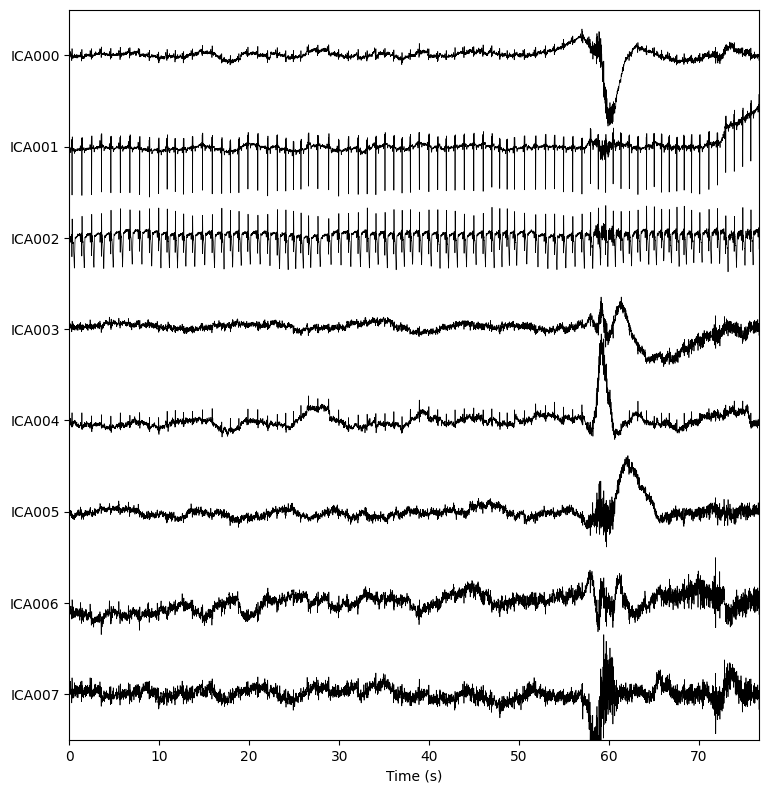

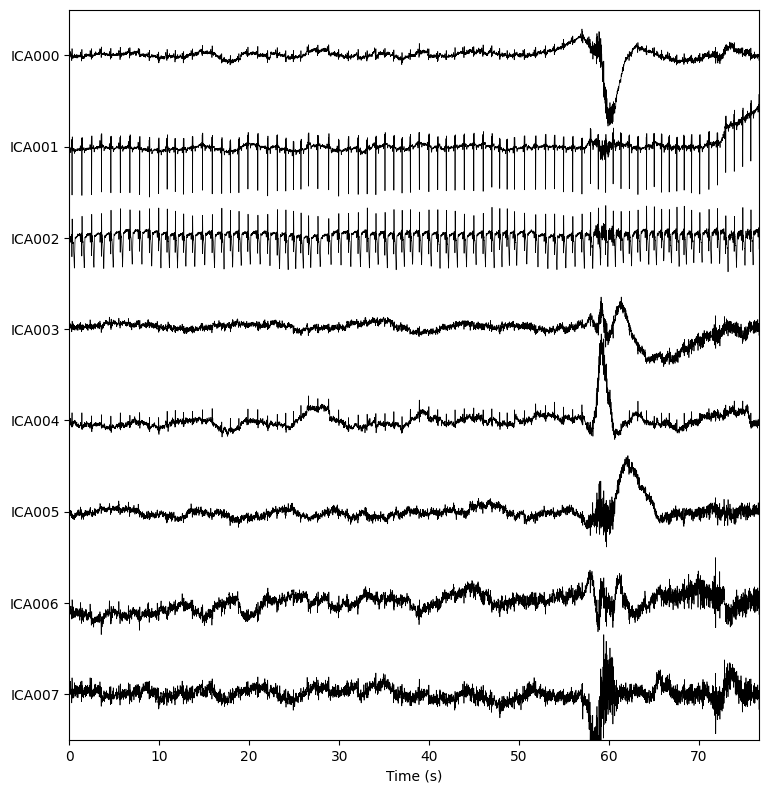

In [106]:
# Apply ICA to the data using MNE
ica = mne.preprocessing.ICA(n_components=channels, random_state=97, max_iter="auto")
ica.fit(notch_filtered_eeg)
ica.plot_sources(notch_filtered_eeg, show_scrollbars=False, start=0, stop=num_points)

In [107]:
ica

Method,fastica
Fit parameters,algorithm=parallelfun=logcoshfun_args=Nonemax_iter=1000
Fit,21 iterations on raw data (39276 samples)
ICA components,8
Available PCA components,8
Channel types,eeg
ICA components marked for exclusion,—


## Remove the EOG artifacts

In [108]:
# # Remove the EOG artifacts from the data using MNE
# eog_indices, eog_scores = ica.find_bads_eog(notch_filtered_eeg)
# ica.plot_scores(eog_scores)
# # No EOG channel(s) found

## Remove Artifact

Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 2 ICA components
    Projecting back using 8 PCA components


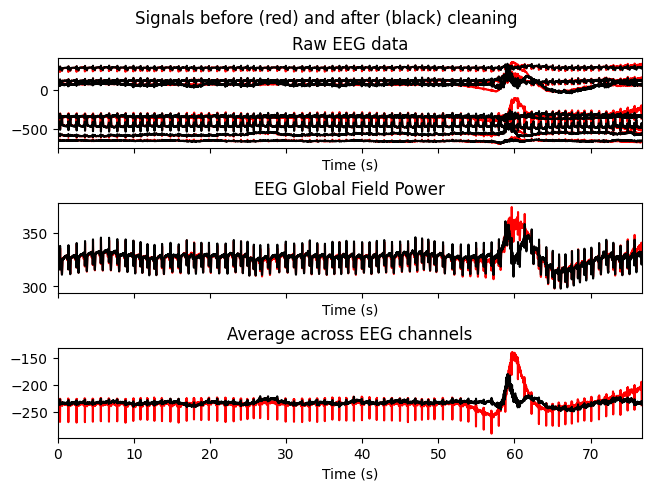

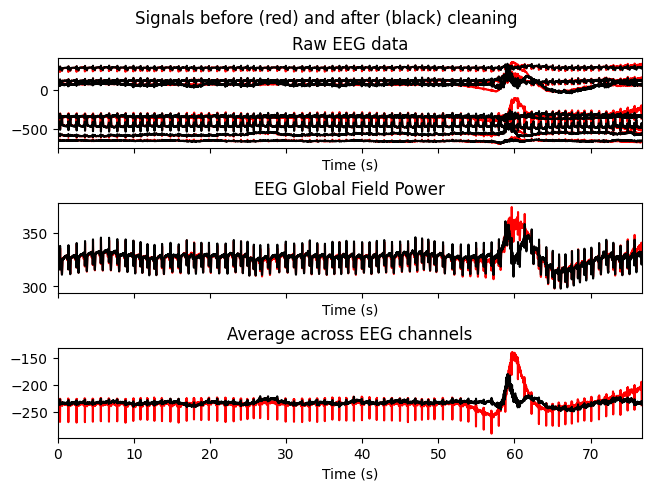

In [109]:
# blinks
exclude = [0, 1]
ica.plot_overlay(notch_filtered_eeg, exclude=[0, 1], picks="eeg", start=0, stop=num_points)

In [110]:
# Get Data that removed 0 component from the data using MNE
ica.exclude = exclude
cleaned_eeg = ica.apply(notch_filtered_eeg)
cleaned_eeg

Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 2 ICA components
    Projecting back using 8 PCA components


Measurement date,Unknown
Experimenter,Unknown
Participant,Unknown
Digitized points,Not available
Good channels,8 EEG
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,512.00 Hz
Highpass,0.10 Hz
Lowpass,30.00 Hz


In [111]:
# Plot the cleaned EEG data using plotly express
cleaned_data = cleaned_eeg.get_data()
cleaned_data_df = pd.DataFrame(cleaned_data.T, columns=[f"Channel_{i+1}" for i in range(cleaned_data.shape[0])])
cleaned_data_df['Time'] = cleaned_eeg.times 
cleaned_data_df = cleaned_data_df[(cleaned_data_df['Time']>0) & (cleaned_data_df['Time']<120)]
fig = px.line(
    cleaned_data_df, 
    x='Time', 
    y=cleaned_data_df.columns, 
    title='Cleaned EEG Data from 15 Channels',
    labels={'Time': 'Time (seconds)', 'value': 'Microvolts [mV]'})
# fig.show()

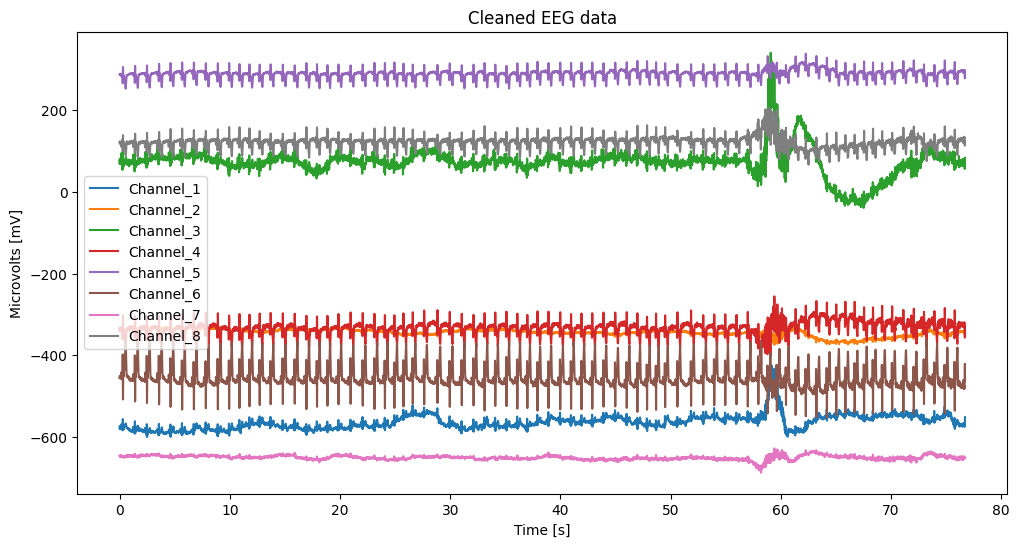

In [112]:
# Plot the cleaned EEG data using pyplot
# The data value on x-axis is recorded in 512 Hz, reformat the x-axis to seconds
x = np.arange(0, data_samples.shape[0], 1)
x = x / 512
# Plot the data
plt.figure(figsize=(12, 6))
plt.plot(x, cleaned_data.T)
plt.xlabel('Time [s]')
plt.ylabel('Microvolts [mV]')
plt.title('Cleaned EEG data')
# Add the channel names to the plot
plt.legend([f"Channel_{i+1}" for i in range(data_shape[1])])
plt.show()

In [113]:
cleaned_data.shape

(8, 39276)

## Power Spectual Density

In [114]:
# Calculate the Power Spectral Density (PSD) of the cleaned EEG data 
# using MNE's mne.io.RawArray.compute_psd() method
# Two methods are used: Welch and Multitaper
welch_psd = cleaned_eeg.compute_psd(method='welch', fmin=0, fmax=30, n_fft=int(20*sampling_rate))
multitaper_psd = cleaned_eeg.compute_psd(method='multitaper', fmin=0, fmax=30)
welch_psd

Effective window size : 20.000 (s)
    Using multitaper spectrum estimation with 7 DPSS windows


Data type,Power Spectrum
Units,eeg: V²/Hz
Data source,Raw
Dims,"channel, freq"
Estimation method,welch
Number of channels,8
Number of frequency bins,601
Frequency range,0.00 – 30.00 Hz


### Delta Band

In [115]:
# Plot the delta band data (frequency between 0 to 4) from welch PSD using plotly express
welch_psd_df = welch_psd.to_data_frame(copy=True)
welch_psd_df_delta = welch_psd_df[(welch_psd_df['freq']>=0) & (welch_psd_df['freq']<=4)]
fig = px.line(
    welch_psd_df_delta, 
    x='freq', 
    y=welch_psd_df_delta.columns[1:], 
    title='Delta Band Power Spectral Density (PSD) of Cleaned EEG Data',
    labels={'freq': 'Frequency (Hz)', 'value': 'Power/Frequency [dB/Hz]'})
# fig.show()

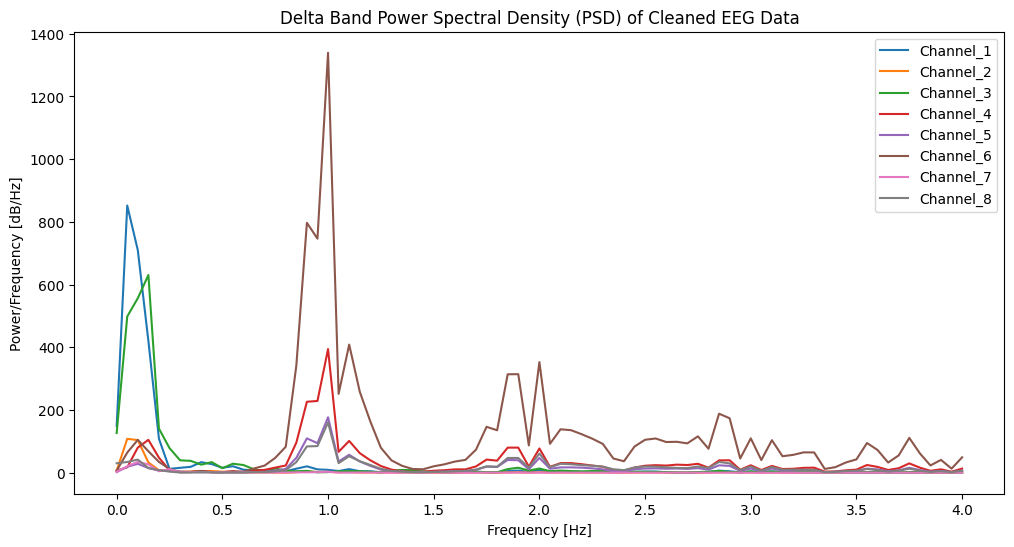

In [116]:
# Plot the delta band data (frequency between 0 to 4) from welch PSD using pyplot
plt.figure(figsize=(12, 6))
plt.plot(welch_psd_df_delta['freq'], welch_psd_df_delta.iloc[:,1:])
plt.xlabel('Frequency [Hz]')
plt.ylabel('Power/Frequency [dB/Hz]')
plt.title('Delta Band Power Spectral Density (PSD) of Cleaned EEG Data')
# Add the channel names to the plot
plt.legend(welch_psd_df_delta.columns[1:])
plt.show()

### Theta Band

In [117]:
# Plot the theta band data (frequency between 4 to 8) from welch PSD using plotly express
welch_psd_df_theta = welch_psd_df[(welch_psd_df['freq']>=4) & (welch_psd_df['freq']<=8)]
fig = px.line(
    welch_psd_df_theta, 
    x='freq', 
    y=welch_psd_df_theta.columns[1:], 
    title='Theta Band Power Spectral Density (PSD) of Cleaned EEG Data',
    labels={'freq': 'Frequency (Hz)', 'value': 'Power/Frequency [dB/Hz]'})
# fig.show()

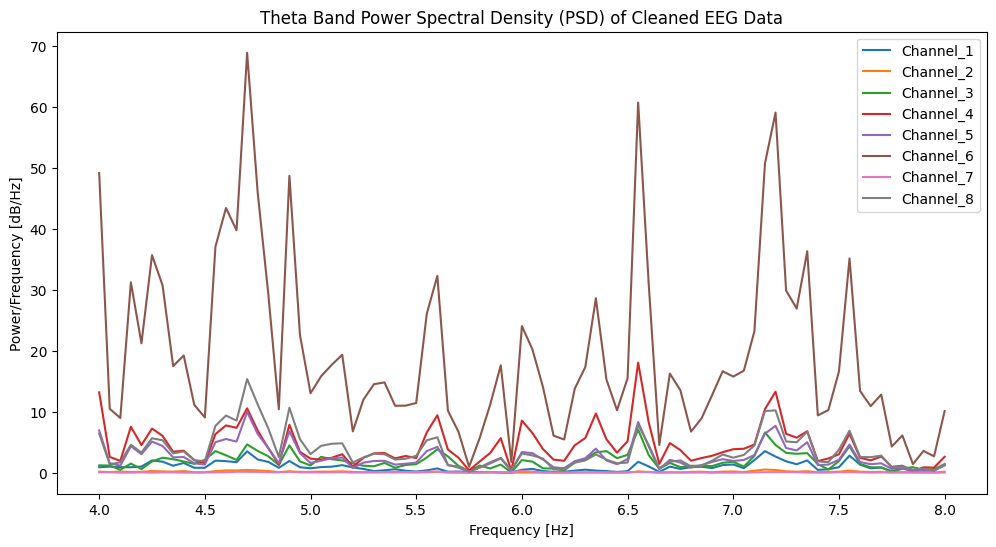

In [118]:
# Plot the theta band data (frequency between 4 to 8) from welch PSD using pyplot
plt.figure(figsize=(12, 6))
plt.plot(welch_psd_df_theta['freq'], welch_psd_df_theta.iloc[:,1:])
plt.xlabel('Frequency [Hz]')
plt.ylabel('Power/Frequency [dB/Hz]')
plt.title('Theta Band Power Spectral Density (PSD) of Cleaned EEG Data')
# Add the channel names to the plot
plt.legend(welch_psd_df_theta.columns[1:])
plt.show()

### Alpha Band

In [119]:
# Plot the alpha band data (frequency between 8 to 12) from welch PSD using plotly express
welch_psd_df_alpha = welch_psd_df[(welch_psd_df['freq']>=8) & (welch_psd_df['freq']<=12)]
fig = px.line(
    welch_psd_df_alpha, 
    x='freq', 
    y=welch_psd_df_alpha.columns[1:], 
    title='Alpha Band Power Spectral Density (PSD) of Cleaned EEG Data',
    labels={'freq': 'Frequency (Hz)', 'value': 'Power/Frequency [dB/Hz]'})
# fig.show()

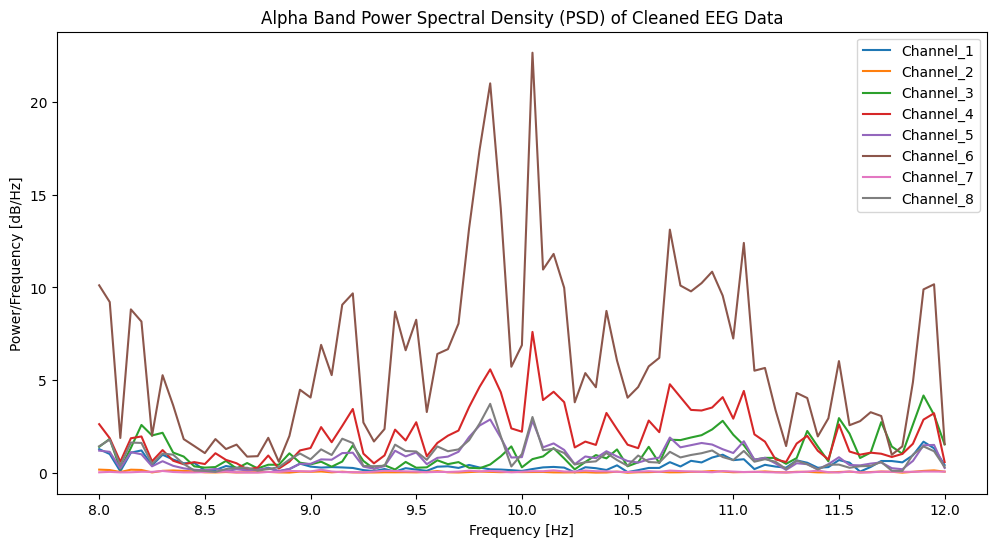

In [120]:
# Plot the alpha band data (frequency between 8 to 12) from welch PSD using pyplot
plt.figure(figsize=(12, 6))
plt.plot(welch_psd_df_alpha['freq'], welch_psd_df_alpha.iloc[:,1:])
plt.xlabel('Frequency [Hz]')
plt.ylabel('Power/Frequency [dB/Hz]')
plt.title('Alpha Band Power Spectral Density (PSD) of Cleaned EEG Data')
# Add the channel names to the plot
plt.legend(welch_psd_df_alpha.columns[1:])
plt.show()

### Beta Band

In [121]:
# Plot the beta band data (frequency between 12 to 30) from welch PSD using plotly express
welch_psd_df_beta = welch_psd_df[(welch_psd_df['freq']>=12) & (welch_psd_df['freq']<=30)]
fig = px.line(
    welch_psd_df_beta, 
    x='freq', 
    y=welch_psd_df_beta.columns[1:], 
    title='Beta Band Power Spectral Density (PSD) of Cleaned EEG Data',
    labels={'freq': 'Frequency (Hz)', 'value': 'Power/Frequency [dB/Hz]'})
# fig.show()

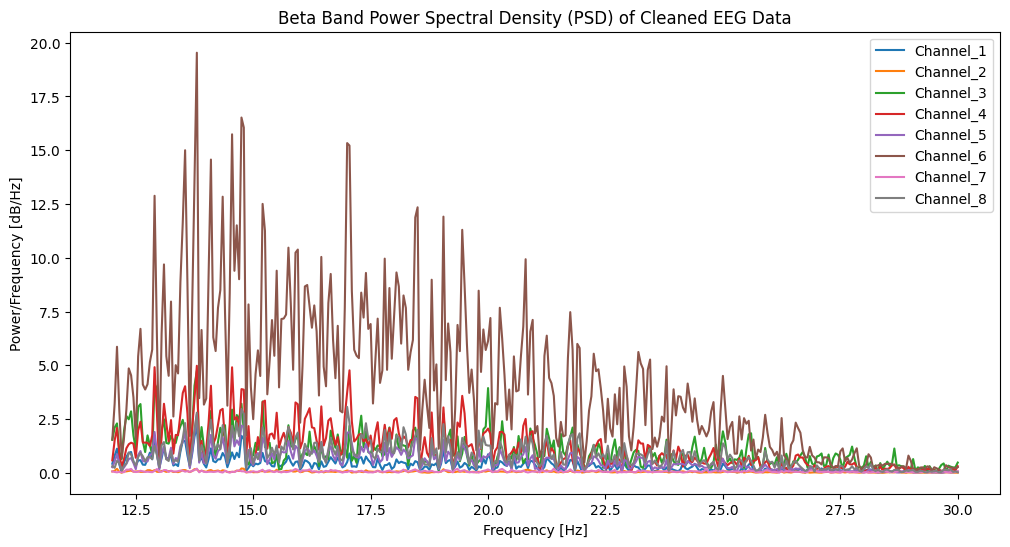

In [122]:
# Plot the beta band data (frequency between 12 to 30) from welch PSD using pyplot
plt.figure(figsize=(12, 6))
plt.plot(welch_psd_df_beta['freq'], welch_psd_df_beta.iloc[:,1:])
plt.xlabel('Frequency [Hz]')
plt.ylabel('Power/Frequency [dB/Hz]')
plt.title('Beta Band Power Spectral Density (PSD) of Cleaned EEG Data')
# Add the channel names to the plot
plt.legend(welch_psd_df_beta.columns[1:])
plt.show()

### Gamma Band

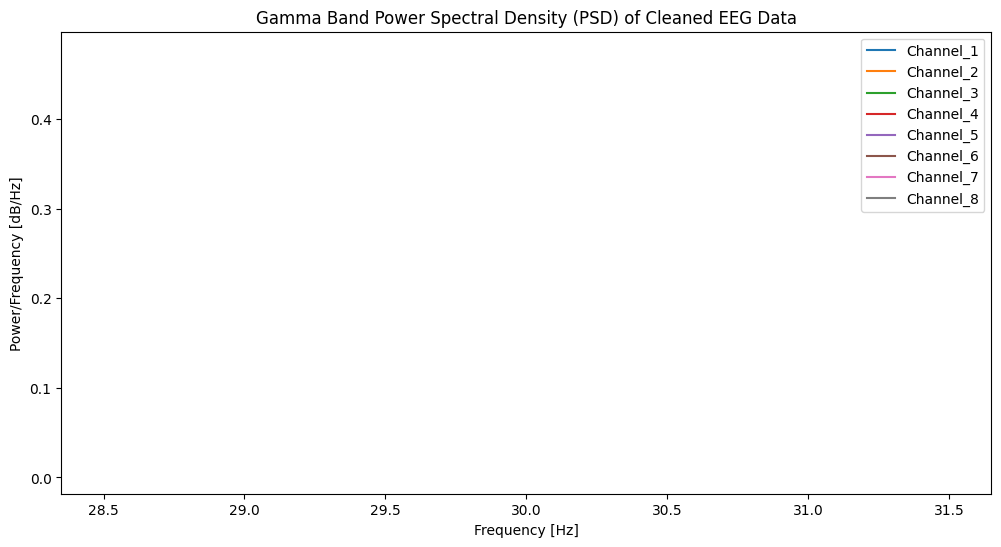

In [123]:
# Plot the gamma band data (frequency between > 30) from welch PSD using pyplot
welch_psd_df_gamma = welch_psd_df[(welch_psd_df['freq']>=30)]
plt.figure(figsize=(12, 6))
plt.plot(welch_psd_df_gamma['freq'], welch_psd_df_gamma.iloc[:,1:])
plt.xlabel('Frequency [Hz]')
plt.ylabel('Power/Frequency [dB/Hz]')
plt.title('Gamma Band Power Spectral Density (PSD) of Cleaned EEG Data')
# Add the channel names to the plot
plt.legend(welch_psd_df_gamma.columns[1:])
plt.show()